# Binary Classification on the Edibility of Mushrooms
Students:
* _Andrea Pepe (matr. 0315903)_
* _Matteo Ciccaglione (matr. 0315944)_ 

In [1]:
import pandas as pd
import sklearn.naive_bayes
import sklearn.linear_model
import sklearn.discriminant_analysis
import matplotlib.pyplot as plt

df = pd.read_csv("dataset/SecondaryData/secondary_data_no_miss.csv",sep=';')
df.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-color,has-ring,ring-type,habitat,season
0,e,1.26,x,g,y,f,d,c,w,5.04,1.73,y,f,f,d,a
1,e,10.32,f,e,b,f,a,c,b,4.68,19.44,w,t,f,d,a
2,p,0.92,x,g,p,f,a,c,p,4.59,1.15,k,f,f,d,u
3,p,4.27,x,t,p,f,x,c,w,4.55,6.52,w,f,f,d,a
4,e,3.08,f,s,w,f,d,d,w,2.67,5.18,w,f,f,m,a


In [2]:
# checks if a str is a number that could be interpreted as a float
def is_number(val):
    """
    Parameters
    ----------
    val: str, arbitrary input

    Returns
    -------
    bool, True if val is interpretable as a float and False else
    """

    try:
        float(val)
        return True
    except ValueError:
        return False

In [94]:
import altair as alt
from dython import nominal
import altair_viewer as view
import scipy
import numpy as np
import seaborn as sns
from altair import pipe, limit_rows, to_values
t = lambda data: pipe(data, limit_rows(max_rows=100000), to_values)
alt.data_transformers.register('custom', t)
alt.data_transformers.enable('custom')


def get_correlation_dataframe(data, **kwargs):
    """
    Parameters
    ----------
    data: pandas.DataFrame
    DataFrame with nominal or metrical columns

    kwargs:
    show_progress: bool, default=False
    Prints each row if True

    Returns
    -------
    var name=data_corr: pandas.DataFrame,
    with two column names and their correlation
    """

    if 'show_progress' not in kwargs:
        kwargs['show_progress'] = False
    data_corr = pd.DataFrame(columns=['variable1', 'variable2', 'correlation', 'correlation_rounded'])
    for variable1 in data:
        for variable2 in data:
            # nominal-nominal -> Theils U
            if type(data[variable1][0]) == str and type(data[variable2][0]) == str:
                corr = nominal.theils_u(data[variable1], data[variable2], nan_replace_value='f')
            # metircal-metrical -> Pearsons R
            elif is_number(data[variable1][0]) and is_number(data[variable2][0]):
                corr = scipy.stats.stats.pearsonr(data[variable1], data[variable2])[0]
                # change range from [-1, 1] to [0, 1] as the other metrics
                corr = (corr + 1) / 2
            # metrical-nominal -> correlation ratio
            elif type(data[variable1][0]) == str and is_number(data[variable2][0]):
                corr = nominal.correlation_ratio(data[variable1], data[variable2], nan_replace_value='f')
            elif type(data[variable2][0]) == str and is_number(data[variable1][0]):
                corr = nominal.correlation_ratio(data[variable2], data[variable1], nan_replace_value='f')
            else:
                print('var1-type: ' + str(type(data[variable1][0])) + ', var2-type: ' + str(type(data[variable2][0])))
                print('var1: ' + str(data[variable1][0]) + ', var2: ' + str(data[variable2][0]))
            new_row = {'variable1': variable1, 'variable2': variable2,
                'correlation': corr, 'correlation_rounded': round(corr, 2)}
            data_corr = pd.concat([data_corr, pd.DataFrame([new_row])], ignore_index=True)
            if kwargs['show_progress']:
                print(new_row)
    return data_corr


def get_correlation_chart(data, **kwargs):
    """
    Parameters
    ----------
    data: pandas.DataFrame
    data with nominal or metrical columns

    kwargs:
    show_progress: bool, default=False,
    prints each row if True

    Returns
    -------
    altair.Chart,
    correlation heatmap of the data columns based on get_correlation_dataframe
    """

    if 'show_progress' not in kwargs:
        kwargs['show_progress'] = False

    data_corr = get_correlation_dataframe(data, show_progress=kwargs['show_progress'])

    base_chart = alt.Chart(data_corr).encode(
        alt.X('variable1:N', sort=data.columns.values),
        alt.Y('variable2:N', sort=data.columns.values)
    )

    corr_chart = base_chart.mark_rect().encode(
        alt.Color('correlation:Q', scale=alt.Scale(scheme='reds')),
    )

    text_chart = base_chart.mark_text().encode(
        alt.Text('correlation_rounded:Q'),
        color = (alt.condition(
            alt.datum.correlation > 0.5,
            alt.value('blue'),
            alt.value('red')
        ))
    )

    return corr_chart# + text_chart


C:\Users\Admin\AppData\Local\Temp\ipykernel_22164\1609542352.py:40: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  corr = scipy.stats.stats.pearsonr(data[variable1], data[variable2])[0]


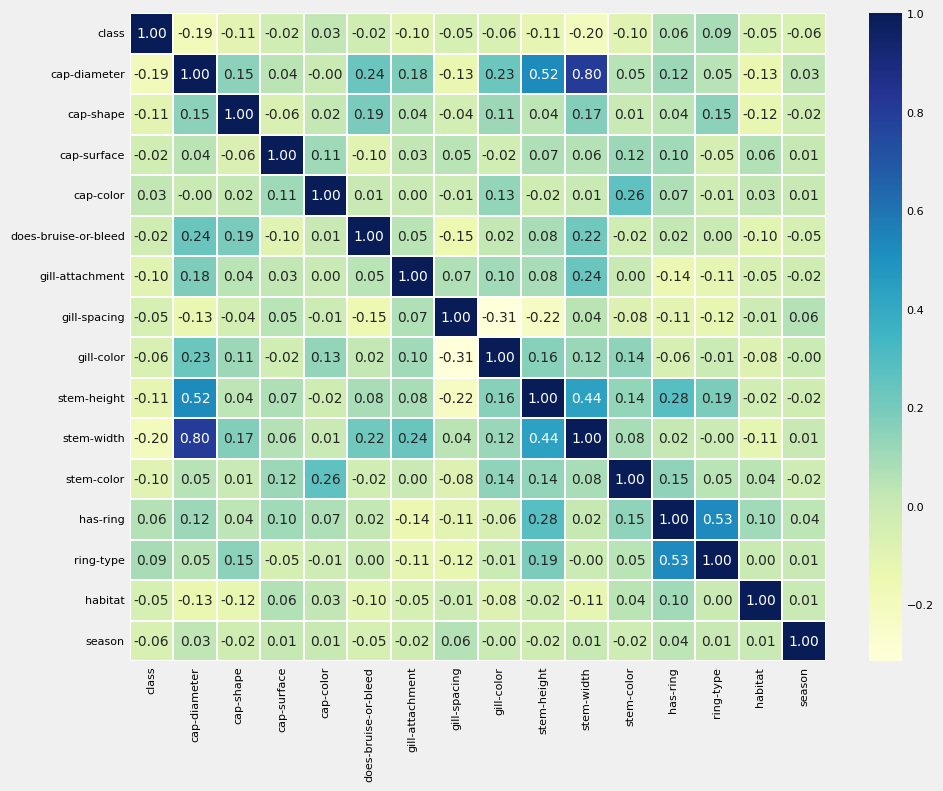

In [97]:
from sklearn.preprocessing import LabelEncoder
encoded_data = df.copy()
le = LabelEncoder()
encoded_data['class'] = le.fit_transform(df['class'])
#encoded_data = pd.get_dummies(encoded_data)
chart = get_correlation_chart(encoded_data)
#dummy = pd.get_dummies(encoded_data)
#dummy.corr()

for col in encoded_data.columns:
    encoded_data[col] = le.fit_transform(encoded_data[col])

dfDummies = pd.get_dummies(encoded_data)
plt.figure(figsize=(10,8))
sns.heatmap(dfDummies.corr(), linewidths=.1, cmap="YlGnBu", annot=True, fmt=".2f")
plt.yticks(rotation=0)
plt.show()


In [92]:
chart.properties(height=500, width=500)

c:\Users\Admin\AppData\Local\Programs\Python\Python310\lib\site-packages\altair\utils\data.py:257: AltairDeprecationWarning: alt.pipe() is deprecated, and will be removed in a future release. Use toolz.curried.pipe() instead.
  warnings.warn(


alt.Chart(...)

In [75]:
# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz

# assign to variables
data = df.copy()
X = data.drop(columns=['class'])
y = data['class']
# encoding: Label encoding for binary class, one-hot encoding for the nominal variables
y = sklearn.preprocessing.LabelEncoder().fit_transform(y)
X = pd.get_dummies(X)
log_reg = sklearn.linear_model.LogisticRegression(max_iter=10000)
lda = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
gnb = sklearn.naive_bayes.GaussianNB()
rf = RandomForestClassifier()
models = [log_reg, lda, gnb, rf]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.20, random_state=100)

In [76]:
for model in models:
    model.fit(X_train, y_train)

In [77]:
from sklearn.metrics import mean_absolute_error, r2_score, f1_score, precision_score, recall_score, accuracy_score, mean_squared_error
import numpy as np
for model in models:
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Precision: {precision_score(y_test, y_pred)}")
    print(f"Recall: {recall_score(y_test, y_pred)}")
    print(f"F1 score: {f1_score(y_test, y_pred)}")
    print(f"R2 score: {r2_score(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print("\n\n")

Accuracy: 0.7695267725560831
Precision: 0.7942362251754517
Recall: 0.7873001776198935
F1 score: 0.7907529918977181
R2 score: 0.06757664590203993
MAE: 0.23047322744391682
RMSE: 0.4800762725275191
Accuracy: 0.7695267725560831



Accuracy: 0.7708367447191747
Precision: 0.7968492123030758
Recall: 0.7861160449970397
F1 score: 0.7914462409656509
R2 score: 0.07287638787915085
MAE: 0.2291632552808253
RMSE: 0.47870999078860393
Accuracy: 0.7708367447191747



Accuracy: 0.7059931226461438
Precision: 0.7187888842803816
Recall: 0.7695381882770871
F1 score: 0.7432983058117092
R2 score: -0.1894608399878419
MAE: 0.2940068773538562
RMSE: 0.5422240103074155
Accuracy: 0.7059931226461438



Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 score: 1.0
R2 score: 1.0
MAE: 0.0
RMSE: 0.0
Accuracy: 1.0





In [78]:
import matplotlib.colors as mcolors
plt.style.use('fivethirtyeight')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12
plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8

colors = ['#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', '#810f7c', 
'#137e6d', '#be0119', '#3b638c', '#af6f09', '#008fd5', '#fc4f30', '#e5ae38', '#6d904f', '#8b8b8b', 
'#810f7c', '#137e6d', '#be0119', '#3b638c', '#af6f09']

cmap = mcolors.LinearSegmentedColormap.from_list("", ["#82cafc", "#069af3", "#0485d1", colors[0], colors[8]])

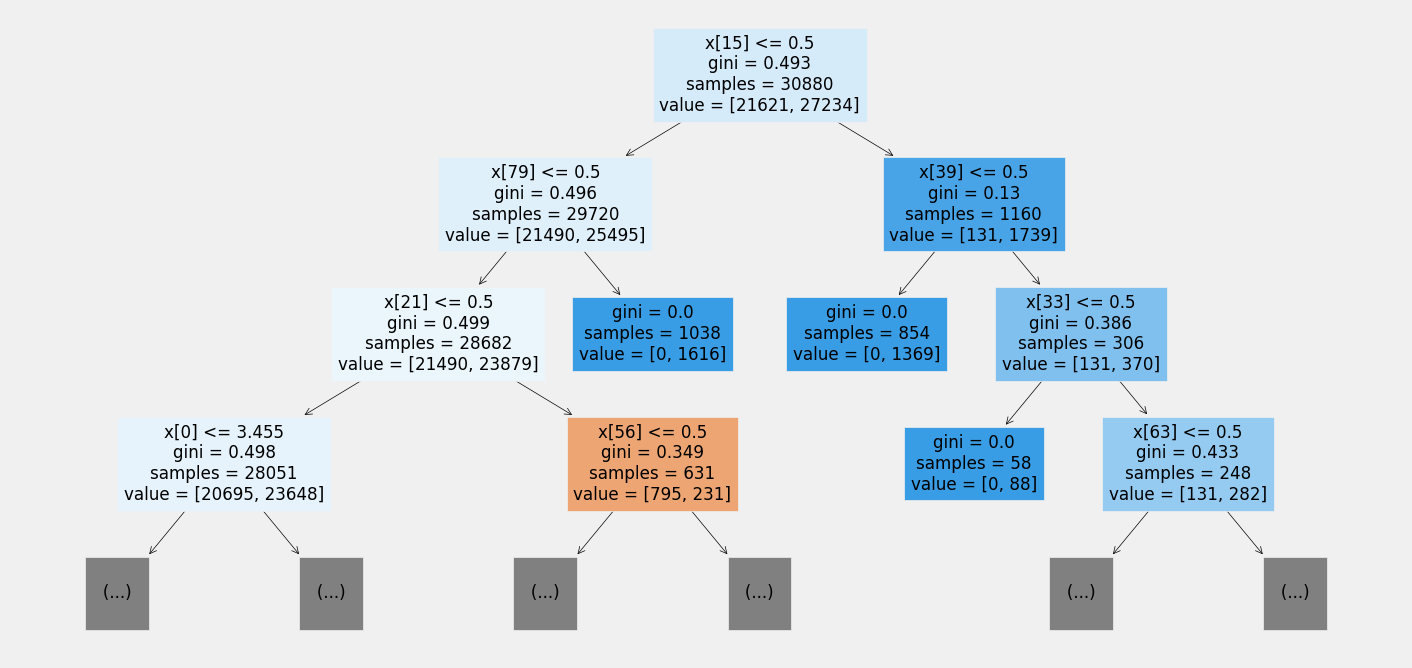

In [79]:
j = len(rf.estimators_) // 2
tree = rf.estimators_[j]

sklearn.tree.plot_tree(tree, max_depth=3, filled=True)
plt.show()

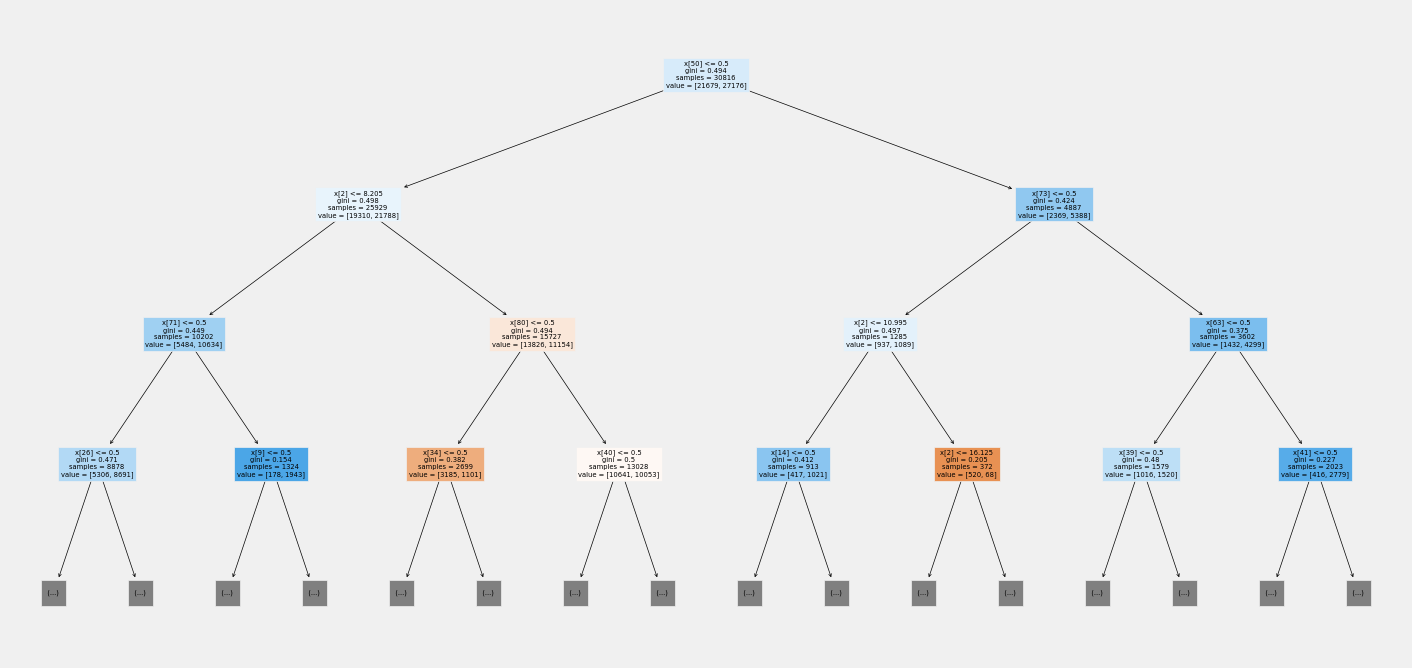

In [80]:
j = 1
tree = rf.estimators_[j]

sklearn.tree.plot_tree(tree, max_depth=3, filled=True)
plt.show()

In [81]:
param_dist = {'n_estimators': randint(1, 500),
              'max_depth': randint(1,50)}

# Create a random forest classifier
rf_constrained = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf_constrained, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train, y_train)
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 29, 'n_estimators': 138}


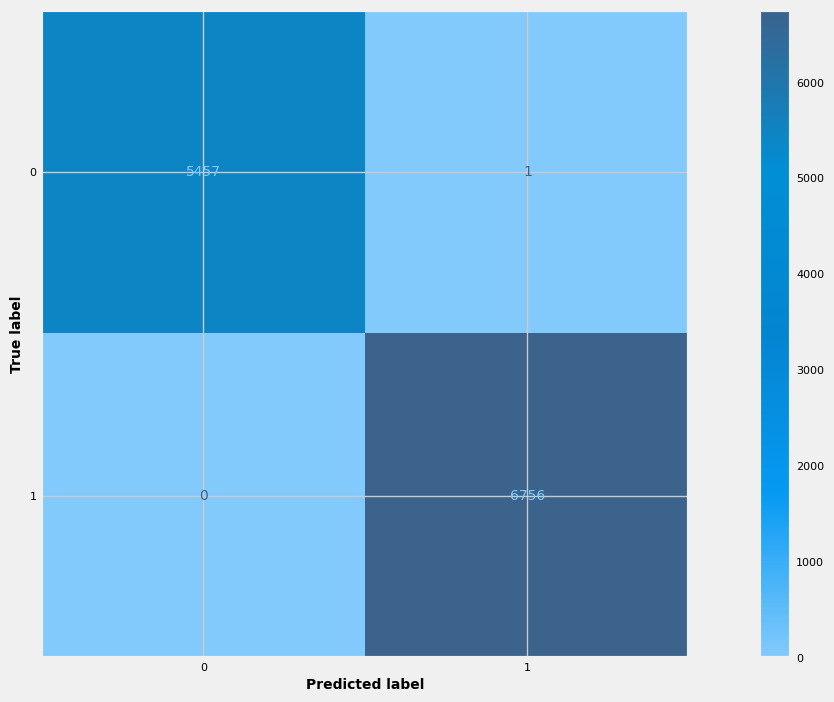

In [84]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=cmap)
plt.show()

In [83]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.9999181267398067
Precision: 0.9998520053278082
Recall: 1.0


# TODO list

* Introduce k-fold cross validation and see how performances vary changing the number of folds;
* Play with RF hyperparameters, introducing constraints and see if the classificator is still good
* Let's try to introduce a threshold to give FN (classified as edible, but poisonous) a larger weight
* Comment correlation matrix in order to justify unnecessity of feature selection
* Try to change the ration of the train/test splitting of the dataset
* Make ROC graphs of the classifiers and choose a pool of metrics to evaluate them

* _A LITTLE MORE TOUGH_: try to apply some dimensionality reduction technique